# Задание

Взять данные по [ссылке](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) и:

- Провести разведочный анализ данных
    - какие зависимости в данных?
    - [сбалансированы](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset) ли классы?
    - основные статистики признаков
- Разделить данные на train/test
    - разделить на обучающую и тестовую подвыборки
    - сравнить статистики подвыборок и генеральной выборки
- Обучить модели классификации
    - какие метрики точности?
    - какая модель лучше всего справилась?

Содержание Датасета:

Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.

В этом наборе данных представлены транзакции, произошедшие за два дня, где у нас 492 мошенничества из 284 807 транзакций. Датасет сильно несбалансирован, на позитивный класс (мошенничество) приходится 0,172% всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA. К сожалению, из-за проблем с конфиденциальностью мы не можем предоставить исходные функции и дополнительную справочную информацию о данных. Особенности V1, V2, ... V28 являются основными компонентами, полученными с PCA, единственными характеристиками, которые не были преобразованы с PCA, являются «Время» и «Количество». Функция «Время» содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Функция 'Amount' - это сумма транзакции, эта функция может быть использована, например, для зависимого от затрат обучения. Признак 'Class' является переменной ответа и принимает значение 1 в случае мошенничества и 0 в противном случае.



In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

sns.set()

In [2]:
df = pd.read_csv('data/creditcard.csv')

In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Так как данные не сбалансированны, нужно проверить на дупликаты. Вдруг это они привели выборку к дизбалансу.

In [5]:
print(f"Размер датасета: {len(df)}")
df.drop_duplicates(inplace=True)
print(f"Размер датасета без дупликатов: {len(df)}")

Размер датасета: 284807
Размер датасета без дупликатов: 283726


In [6]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Знчаений NaN нет

В описании к датасету сказано, что классы не сбалансированны. Проверим это:

In [7]:
count_positive = round(df['Class'].value_counts()[0]/len(df) * 100, 3)
count_negative = round(df['Class'].value_counts()[1]/len(df) * 100, 3)
print(f"Честных людей: {count_positive}")
print(f"Нечестных людей: {count_negative}")

Честных людей: 99.833
Нечестных людей: 0.167


Посмотрим основные статистики

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


Посмотрим также корреляцию признаков

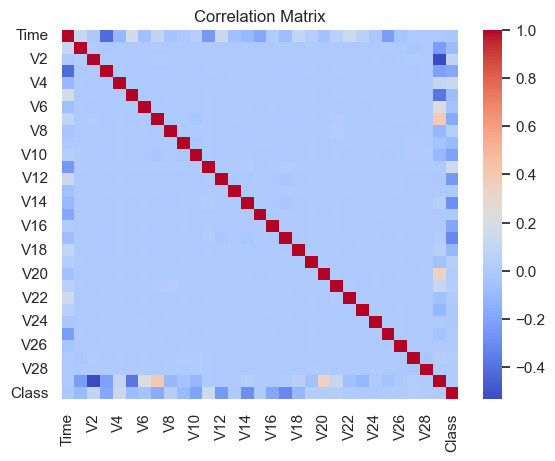

In [9]:
sns.heatmap(df.corr(), cbar=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Корреляция между признаками мала

Исследую связь между признаками. Строить pairplot для всех данных не получится в виду вычислительной мощности, поэтому построю только для части параметров

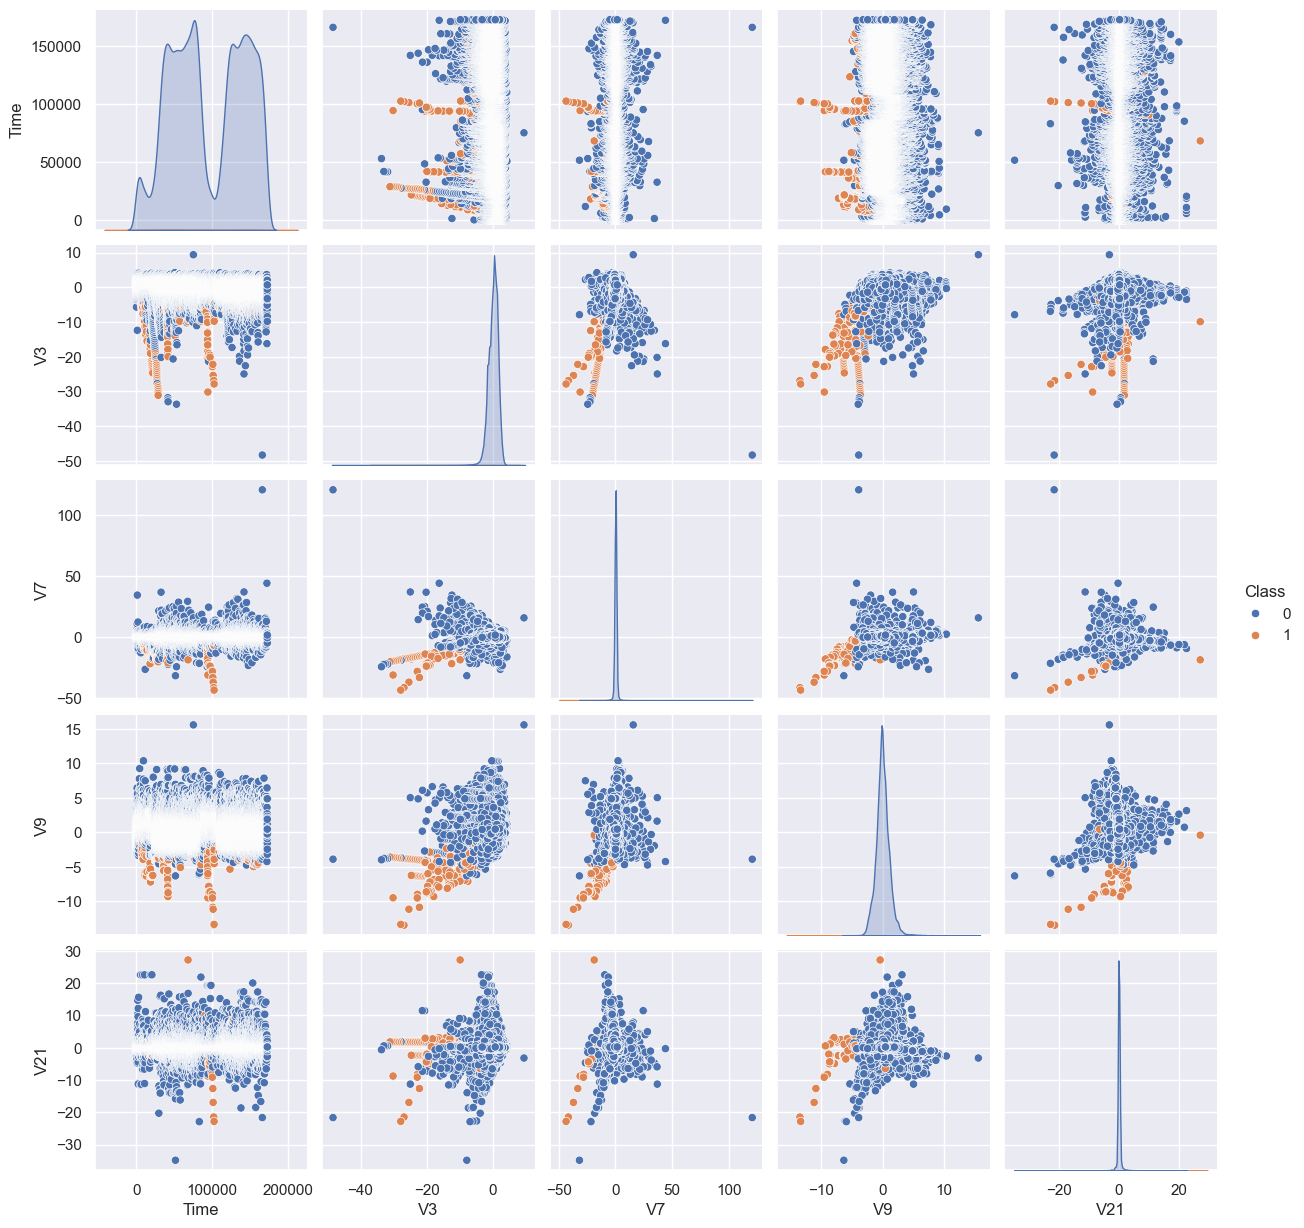

In [10]:
neaded_features = ['Class', 'Time', 'V3', 'V7', 'V9', 'V21']
sns.pairplot(df[neaded_features], hue='Class', diag_kind='kde')
plt.show()

По получившимся результатам видно, что во многих случаях мошенников можно отделить, но только при использовании нелинейных моделей.
А кто говорил, что будет просто?

## LogReg

Хотя здесь нет линейной зависимости, но мы имеем бинарную клаассификацию, корреляция признаков мала. + очень просто может разботать с несбалансированными данными

In [9]:
X = df.drop(['Class'], axis = 1)
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

Проверю процент мошеннических операций в выборках:

In [10]:
scammer_train = round(y_train.value_counts()[1] / y_train.shape[0] * 100, 3)
scammer_test = round(y_test.value_counts()[1] / y_test.shape[0] * 100, 3)
print(f'Процент мошеннических операций в обучающей выборке: {scammer_train}%')
print(f'Процент мошеннических операций в тестовой выборке: {scammer_test}%')

Процент мошеннических операций в обучающей выборке: 0.167%
Процент мошеннических операций в тестовой выборке: 0.167%


**Данные разбились пропорционально, это хорошо**

Сравню статистики получившихся выборок:

In [11]:
X_train.describe() - X_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,...,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000
mean,349.321162,-0.002689,-0.000255,0.002039,0.010443,0.010629,0.002622,-0.000741,0.002758,-0.006590,...,0.001912,0.003912,-0.000073,-0.001938,0.001932,-0.001253,0.000507,-0.000846,0.003402,-0.503359
std,15.555743,-0.002333,-0.001586,-0.008102,0.017189,-0.064794,-0.023878,-0.094303,-0.016544,-0.002261,...,-0.049513,0.009040,0.000473,-0.012400,-0.002718,-0.001623,-0.003465,-0.015500,0.005570,-25.075175
min,-1.000000,-18.849443,-9.371029,14.644605,-0.123054,81.651178,-4.231194,-10.317913,-22.528299,-2.591540,...,30.850830,-11.941035,1.433721,11.978740,0.011778,1.598770,-0.070221,-12.670435,3.719188,0.000000
25%,238.500000,0.000747,0.003226,0.007934,0.002752,0.004931,0.003387,0.000541,0.000074,-0.001479,...,0.000850,-0.000129,0.002692,-0.000655,0.001579,-0.002673,0.001735,0.000533,0.001122,0.210000
50%,352.000000,-0.011077,0.002021,-0.007644,0.001674,0.005545,-0.002510,0.001078,0.001109,-0.001981,...,0.000647,0.001309,-0.000184,-0.001124,0.000439,-0.001868,0.001958,-0.000102,0.000847,0.180000
75%,272.750000,-0.003153,0.006808,-0.000498,0.013695,0.005580,0.004482,0.006003,0.000725,-0.005851,...,0.000617,0.000876,0.001640,0.000833,0.001836,-0.000798,-0.002883,0.001037,0.001940,0.700000
max,6.000000,0.015723,4.639080,5.280842,0.159807,1.890204,-51.908557,-86.286317,-0.419436,5.202106,...,-1.303695,7.139053,2.230857,0.444867,-0.568207,1.448738,0.054100,-19.459797,17.981087,-6781.160000


**Как видим, основные статистики почти совпадают**

Стандартизируй данные:

In [12]:
sscaler = StandardScaler()
X_train_sscaler = sscaler.fit_transform(X_train)
X_test_sscaler = sscaler.transform(X_test)

Перейдем к оубчению и предсказанию

In [13]:
log_reg = LogisticRegression(class_weight='balanced')

log_reg.fit(X_train_sscaler, y_train)
y_pred = log_reg.predict(X_test_sscaler)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.98     85118



Получились следующие результаты:
1. precision: точность для класса 0 составляет 100%, а для класса 1 - всего 5 % => предсказывая мошеннические транзакции модель чаще ошибается.
2. recall: показатели recall для обоих классов достаточно высокие. Значит данная модель успешно предсказывает фактически положительные объекты.
3. f1-score: хдесь видно, что f1-score для класса 1 низкий, что свидетельствует о трудностях модели в обнаружении мошеннических операциях.

Мы хотим увеличить precission, чтобы меньше порядочных операций наша модель предсказывала мошенническими. Для этого попробую использовать другой мтеод классификации - Случайный лес.


## Random Forest

Попробую данную модель без семплирования и с ним, а после сравню результаты. (У пересэмплирования качество, как правило выше, т.к. мы используем все данные)

In [15]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier

In [16]:
rand_forest = RandomForestClassifier(random_state=42, n_jobs=-1)

rand_forest.fit(X_train_sscaler, y_train)
y_pred = rand_forest.predict(X_test_sscaler)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.78      0.86       142

    accuracy                           1.00     85118
   macro avg       0.98      0.89      0.93     85118
weighted avg       1.00      1.00      1.00     85118



Сравнение результатов двух методов:
1. Presission:
<ul>
   <li> оба метода показывают высокую точность для класса 0 (положительных людей) </li>
   <li> случайный лес имеет более высокую точность для класса 1 (96%) по сравнению с логистической регрессией (5%)</li>
</ul>

2. Recall:
<ul>
    <li>оба метода успешно предсказывают класс 0 с высоким recall.</li>
    <li>случайный лес имеет recall ниже для класса 1 (77%), чем логистическая регрессия (89%).</li>
</ul> 

3. F1-score:
<ul>
    <li>Случайный лес показывает лучший F1-score для класса 1 (86%) по сравнению с логистической регрессией (10%).</li>
</ul>

### Выводы:

<ul>
    <li>Оба метода демонстрируют высокую точность для класса 0, что может быть связано с дисбалансом классов в данных.</li>
    <li>Случайный лес показывает более уравновешенные метрики precision и recall для класса 1, что может быть важным в задачах обнаружения мошеннических операций.</li>
    <li>Логистическая регрессия, столкнулась с трудностями в обнаружении мошеннических транзакций, о чем могут говорить низкие значения F1-score и precision для класса 1.</li>
</ul>

Итак, случайный лес, по всей видимости, более успешен в данной задаче классификации, особенно когда речь идет о предсказании мошеннических транзакций. 

Но на сколько изменятся результаты, если мы сделаем **перебалансировку данных**? Давайте поглядим..

In [18]:
sampler = RandomOverSampler(random_state=42)
X_train_sanpai, y_train_sanpai = sampler.fit_resample(X_train_sscaler, y_train)
X_test_sanpai, y_test_sanpai = sampler.fit_resample(X_test_sscaler, y_test)

In [19]:
rand_forest.fit(X_train_sanpai, y_train_sanpai)
y_pred_sanppai = rand_forest.predict(X_test_sscaler)

In [23]:
print(classification_report(y_test, y_pred_sanppai))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.73      0.83       142

    accuracy                           1.00     85118
   macro avg       0.98      0.87      0.92     85118
weighted avg       1.00      1.00      1.00     85118



In [20]:
y_pred_sanppai_samp = rand_forest.predict(X_test_sanpai)

In [21]:
print(classification_report(y_test_sanpai, y_pred_sanppai_samp))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     84976
           1       1.00      0.73      0.85     84976

    accuracy                           0.87    169952
   macro avg       0.89      0.87      0.86    169952
weighted avg       0.89      0.87      0.86    169952



In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
conf_matrix_before_senpai = confusion_matrix(y_test, y_pred)
print(conf_matrix_before_senpai)

[[84971     5]
 [   31   111]]


In [26]:
conf_matrix_after_senpai = confusion_matrix(y_test, y_pred_sanppai)
print(conf_matrix_after_senpai)

[[84972     4]
 [   38   104]]


Модель ДО пересэмплирования и ПОСЛЕ практически **одинаково хорошо предсказывает добротные операции**.
Однако уменьшились с 5 до 4 ложноположительных случаев, что говорит о том, что *добротные транзакции РЕЖЕ классифицируются как мошеннические*. Это хорошо.
НО **ложноотрицательные случаи выросли**! Было 32, стало 38 мошеннических операций, которые классифицировались добротными. Это грустно(

### Сравнение Метрик точности RandomForest, обученных на сэмплированных данных, при тестировании на сэмплированных и не сэмплированных данных:
1. Presission:
<ul>
   <li> Данная метрика для класса 0 лучше при тестировании не на сэмплированных данных и составляет 100%, тогда как в другом случае всего 79% </li>
   <li> Однако для класса 1 (мошеннические операции) метрика поднялась с 96% до 100% при предсказании на сэмплированных данных</li>
</ul>


2. Recall:
<ul>
    <li> recall в обоих случаях показал одинаковые результаты для обоих классов</li>
</ul> 


3. F1-score:
<ul>
    <li> Ну и тут соответственно для класса 0 при тестировании на сэмплированных данных метрика понижается со 100% до 88% по сравнению с предсказанием на несэмплированных данных, а для класса 1 немного поднялась с 83% до 85%</li>
</ul>

**Как итог**:
В целом отличия не большие, однако recall значительно снизился. Поэтому в данном случае рекомендую модель, обученную на сэмплированных данных, применять на не сэмплированных данных.

### ИТОГО:

Итак, после RandomOverSampler моя модель стала чуть менее точной, а именно чуть снизила ложноположительные случаи, но увеличила ложноотрицательные!
Но в данных реалиях наиболее важно классифицировать Мошенников(их операции), а после пересемплирования верно предсказать мошенников удалось на 6 операций меньше(

Поэтому оптимальной моделью я считаю RandomForestClassifier без сэмплирования, в виду того, что нам важна минимизация ложноотрицательных случаев (нужно больше мошеннических операций предсказывать)